# Video Search




## Step 1:  Video library (10 points)

Write a python API  that will download the video and its closed captions from youtube. Make sure to document how one can use your API. Use this to download the following videos from youtube along with thei captions:

https://www.youtube.com/watch?v=wbWRWeVe1XE

https://www.youtube.com/watch?v=FlJoBhLnqko

https://www.youtube.com/watch?v=Y-bVwPRy_no

In [6]:
from pytube import YouTube
from youtube_transcript_api import YouTubeTranscriptApi, NoTranscriptFound
from youtube_transcript_api.formatters import TextFormatter
import os

def n(m, p):
    """
    Download a video from YouTube using its video ID.
    """
    q = f"https://www.youtube.com/watch?v={m}"
    try:
        r = YouTube(q)
        s = r.streams.get_highest_resolution()
        t = s.download(output_path=p)
        print(f"Download completed! {r.title} has been downloaded to {p}")
        return r.title
    except Exception as u:
        print(f"Error downloading the video {m}: {u}")
        return None

def o(m, v, p):
    """
    Download the transcript for a YouTube video using its video ID.
    """
    try:
        w = YouTubeTranscriptApi.get_transcript(m)
        x = TextFormatter()
        y = x.format_transcript(w)
        v = v.replace('/', '_').replace('\\', '_').replace(':', '_').replace('*', '_').replace('?', '_').replace('"', '_').replace('<', '_').replace('>', '_').replace('|', '_')
        z = os.path.join(p, f"{v}_transcript.txt")
        with open(z, "w", encoding="utf-8") as file:
            file.write(y)
        print(f"Transcript downloaded: {z}")
    except NoTranscriptFound:
        print(f"No transcript found for video: {m}")

def main():
    #YT Id's
    a = [
        "wbWRWeVe1XE",
        "FlJoBhLnqko",
        "Y-bVwPRy_no"
    ]
    b = "downloaded_videos"
    if not os.path.exists(b):
        os.makedirs(b)
        print(f"Created folder: {b}")
    for m in a:
        v = n(m, b)
        if v:
            o(m, v, b)

if __name__ == "__main__":
    main()


Download completed! What Does 'High-Quality' Preschool Look Like? | NPR Ed has been downloaded to downloaded_videos
Transcript downloaded: downloaded_videos\What Does 'High-Quality' Preschool Look Like_ _ NPR Ed_transcript.txt
Download completed! How Green Roofs Can Help Cities | NPR has been downloaded to downloaded_videos
Transcript downloaded: downloaded_videos\How Green Roofs Can Help Cities _ NPR_transcript.txt
Download completed! Why It’s Usually Hotter In A City | Let's Talk | NPR has been downloaded to downloaded_videos
Transcript downloaded: downloaded_videos\Why It’s Usually Hotter In A City _ Let's Talk _ NPR_transcript.txt


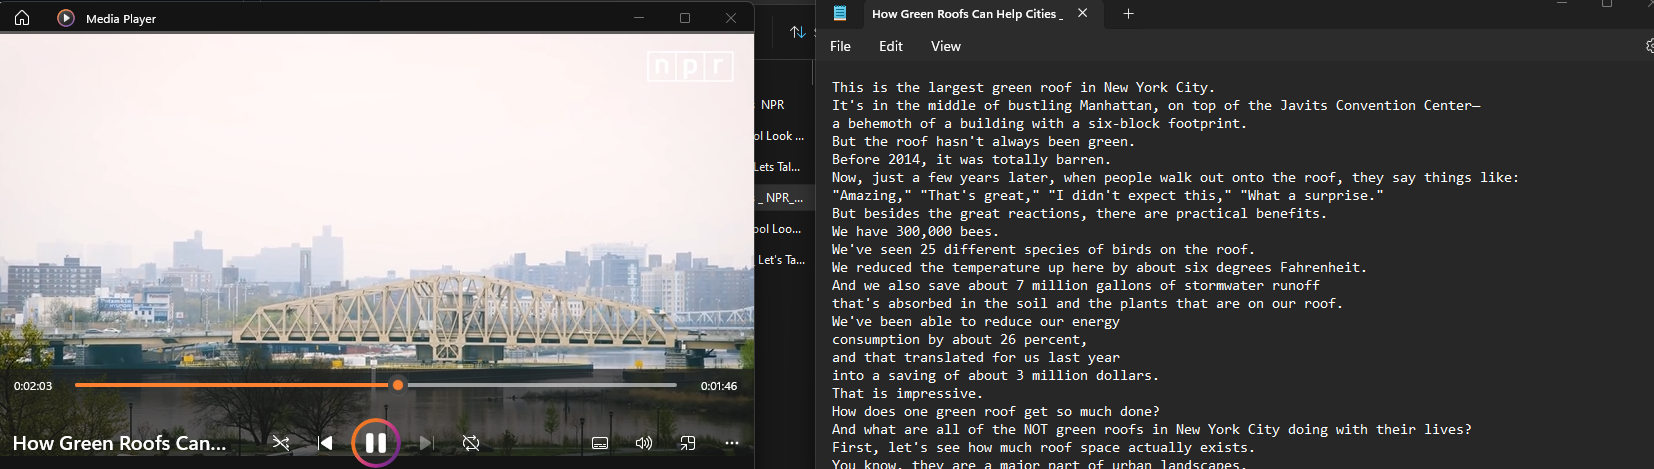

## Step 2: Video indexing pipeline (90 points)

In this step you will build and train your models to extract embeddings for the frames of your videos and store the extracted information in a database such as postgres for indexing the videos.

### 2.1 Preprocess the video (15 points)

You can use opencv, ffmpeg, gstreameer, https://pytorchvideo.org/ or any other library to implement the preprocessing steps as shown below:
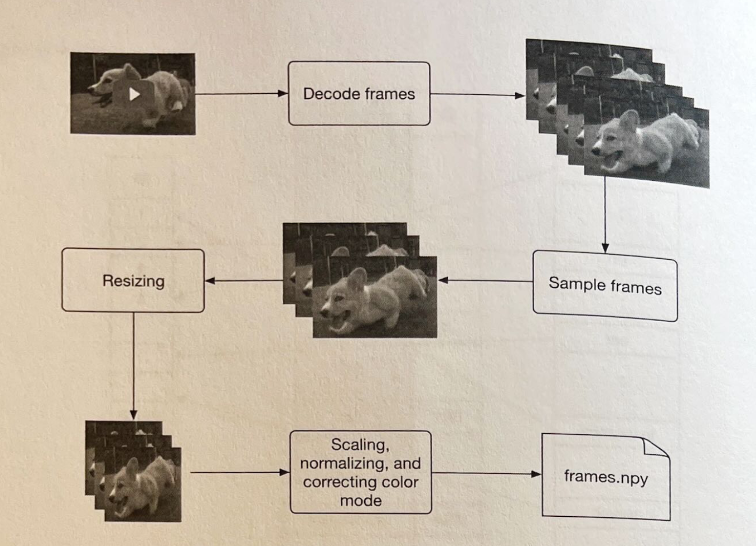



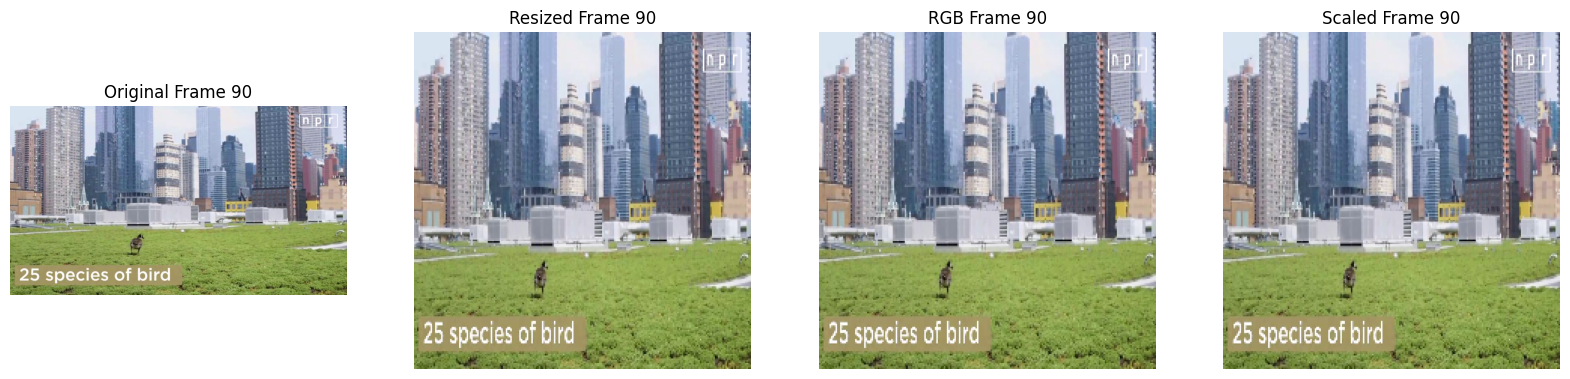

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def video_preprocess_display(video_src, newSize, step):
    videoFile = cv2.VideoCapture(video_src)
    
    totalFrames = int(videoFile.get(cv2.CAP_PROP_FRAME_COUNT))
    selectedFrames = range(0, totalFrames, step)
    
    for frameIndex in selectedFrames:
        videoFile.set(cv2.CAP_PROP_POS_FRAMES, frameIndex)
        success, frame = videoFile.read()
        if not success:
            break
        
        fig, plots = plt.subplots(1, 4, figsize=(20, 5))
        
        original = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plots[0].imshow(original)
        plots[0].set_title(f"Original Frame {frameIndex}")
        plots[0].axis('off')
        
        resized = cv2.resize(frame, newSize)
        plots[1].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        plots[1].set_title(f"Resized Frame {frameIndex}")
        plots[1].axis('off')
        
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        plots[2].imshow(rgb)
        plots[2].set_title(f"RGB Frame {frameIndex}")
        plots[2].axis('off')
        
        normalized = rgb / 255.0
        plots[3].imshow(normalized)
        plots[3].set_title(f"Scaled Frame {frameIndex}")
        plots[3].axis('off')
        
        plt.show()
        clear_output(wait=True)
    
    videoFile.release()

video_src = 'test2.mp4'
newSize = (224, 224)
step = 30

video_preprocess_display(video_src, newSize, step)


### 2.2 Detecting objects (25 points)

Use any of the pretrained object-detectors to detect objects belonging to MS COCO classes.
For each video, for each frame where a detection is found, compile and report the results in the following tabular structure :

[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]

Feel free to finetune your detectors if required. If you notice that your model performs better on a different video from this [channel](https://www.youtube.com/@NPR), document this and you can use this video for the rest of this assignment.



In [3]:
import torch
import torchvision.transforms as T
import cv2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import pandas as pd
import numpy as np
import os


def transform(frame, min_size=800):

    h, w, _ = frame.shape
    scale = min_size / min(h, w)
    if h < w:
        newh, neww = min_size, scale * w
    else:
        newh, neww = scale * h, min_size
    frame_resized = cv2.resize(frame, (int(neww), int(newh)))
    

    frame_resized = T.ToTensor()(frame_resized)
    return frame_resized.unsqueeze(0)


model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()


label_map = {
    1: "person", 2: "bicycle", 3: "car", 4: "motorcycle",
    5: "airplane", 6: "bus", 7: "train", 8: "truck",
    9: "boat", 10: "traffic light", 11: "fire hydrant",
    13: "stop sign", 14: "parking meter", 15: "bench",
    16: "bird", 17: "cat", 18: "dog", 19: "horse",
    20: "sheep", 21: "cow", 22: "elephant", 23: "bear",
    24: "zebra", 25: "giraffe", 27: "bee", 28: "umbrella",
    31: "handbag", 32: "Tie", 33: "suitcase", 34: "frisbee",
    35: "skis", 36: "snowboard", 37: "bee", 38: "kite",
    39: "baseball bat", 40: "baseball glove", 41: "skateboard",
    42: "surfboard", 43: "tennis racket", 44: "bottle",
    46: "wine glass", 47: "cup", 48: "fork", 49: "knife",
    50: "spoon", 51: "bowl", 52: "banana", 53: "apple",
    54: "sandwich", 55: "orange", 56: "broccoli", 57: "carrot",
    58: "hot dog", 59: "pizza", 60: "donut", 61: "cake",
    62: "chair", 63: "couch", 64: "potted plant", 65: "bed",
    67: "dining table", 70: "toilet", 72: "tv", 73: "laptop",
    74: "mouse", 75: "remote", 76: "keyboard", 77: "cell phone",
    78: "microwave", 79: "oven", 80: "toaster", 81: "sink",
    82: "refrigerator", 84: "book", 85: "clock", 86: "vase",
    87: "scissors", 88: "teddy bear", 89: "hair drier", 90: "toothbrush"
}


def detect_objects(frame):

    frame = transform(frame)
    
    with torch.no_grad():
        prediction = model(frame)
    
    return prediction

def save_detected_objects(frame, detections, frameNum, save_dir='detected_objects'):
  
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i, detection in enumerate(detections['boxes']):
        score = detections['scores'][i].item()
        if score > 0.5:  
            
            xmin, ymin, xmax, ymax = map(int, detection)
           
            detected_object_img = frame[ymin:ymax, xmin:xmax]
            
            
            label_id = detections['labels'][i].item()
            label = label_map.get(label_id, 'Unknown').replace(" ", "_") 
            
           
            obj_filename = f'{save_dir}/{label}_{frameNum}_object{i}.png'
            cv2.imwrite(obj_filename, detected_object_img)


def process_video(video_path, skip_frames=5):
    cap = cv2.VideoCapture(video_path)
    frameNum = 0
    fps = cap.get(cv2.CAP_PROP_FPS) 
    detections_list = []  
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if frameNum % skip_frames == 0:
            detections = detect_objects(frame)[0]
            
       
            save_detected_objects(frame, detections, frameNum)
            
            for i in range(len(detections['labels'])):
                score = detections['scores'][i].item()
                if score > 0.5: 
                    label_id = detections['labels'][i].item()
                    label = label_map.get(label_id, 'Unknown')
                    box = detections['boxes'][i].numpy().astype(int)
                    timestamp = frameNum / fps
                    
               
                    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                    cv2.putText(frame, f'{label}: {score:.2f}', (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    
                   
                    detections_list.append([
                        video_path, frameNum, timestamp, label_id, label, score, box.tolist()
                    ])
            
            cv2.imshow('Video', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        
        frameNum += 1
    
    cap.release()
    cv2.destroyAllWindows()
    return pd.DataFrame(detections_list, columns=['vidId', 'frameNum', 'timestamp', 'detectedObjId', 'detectedObjClass', 'confidence', 'bbox info'])


detections_df = process_video('test2.mp4', skip_frames=10)


detections_df.to_csv('detections.csv', index=False)

print(detections_df.head())


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


       vidId  frameNum  timestamp  detectedObjId detectedObjClass  confidence  \
0  test2.mp4         0   0.000000              1           person    0.996621   
1  test2.mp4        10   0.416437              1           person    0.998356   
2  test2.mp4        10   0.416437             32              Tie    0.625499   
3  test2.mp4        20   0.832874              1           person    0.735812   
4  test2.mp4        30   1.249311             37              bee    0.842270   

              bbox info  
0   [36, 136, 902, 794]  
1   [30, 109, 908, 798]  
2  [296, 465, 465, 785]  
3  [724, 478, 796, 538]  
4   [770, 93, 810, 150]  


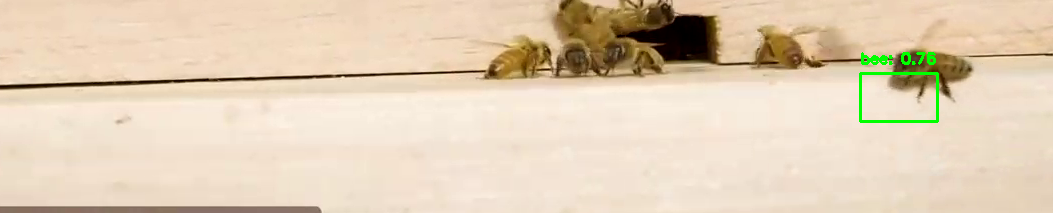
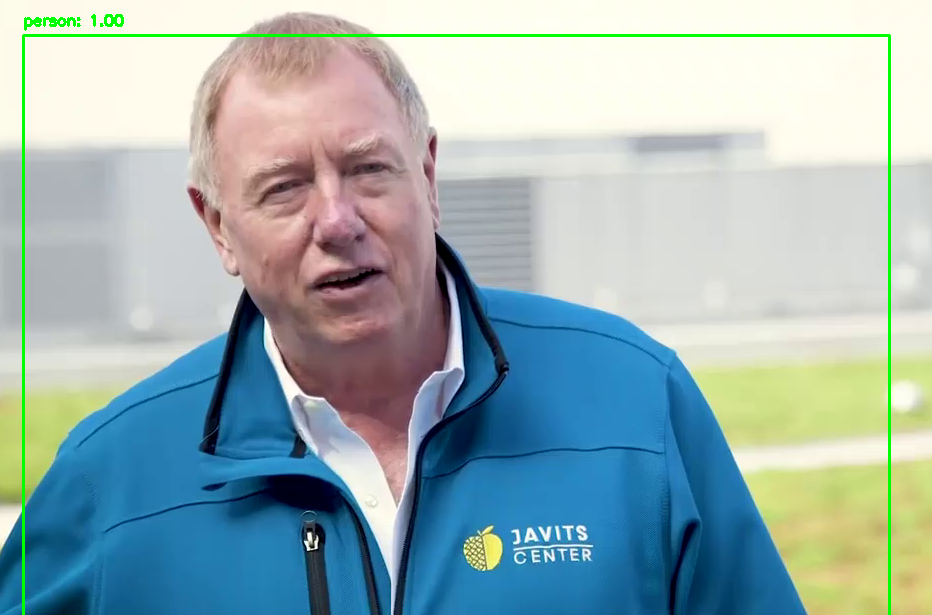

### 2.3 Embedding model (30 points)

Develop a convolutional autoencoder such as [the one described here](https://blog.keras.io/building-autoencoders-in-keras.html) whose input will be all the objects detected in each frame (not the entire frame!), if any.
Note : You can downsample the frame rate of your original video to avoid long training/processing times. For a given input image, the autoencoder should output it's small vector embedding.

Train your autoencoder on the COCO dataset for classes which get detected in the given list of videos.


In [ ]:
from PIL import Image
import numpy as np
import random
import os

input_dir = "detected_objects"
output_dir_deconstructed = "deconstructed"
output_dir_reconstructed = "reconstructed_with_gaps"


os.makedirs(output_dir_deconstructed, exist_ok=True)
os.makedirs(output_dir_reconstructed, exist_ok=True)


def process_image(image_path, output_name):
    image = Image.open(image_path)
    

    width, height = image.size
    box_width = width // 3
    box_height = height // 3
    

    boxes = [(image.crop((j * box_width, i * box_height, (j + 1) * box_width, (i + 1) * box_height)))
             for i in range(3) for j in range(3)]
    

    shuffled_boxes = random.sample(boxes, len(boxes))
    

    deconstructed_image = Image.new('RGB', (width, height))
    for i, box in enumerate(shuffled_boxes):
        x = (i % 3) * box_width
        y = (i // 3) * box_height
        deconstructed_image.paste(box, (x, y))
    

    deconstructed_image.save(os.path.join(output_dir_deconstructed, output_name + "_deconstructed.png"))
    
    gap = 10
    new_width = width + gap * 2
    new_height = height + gap * 2
    reconstructed_image = Image.new('RGB', (new_width, new_height), "white")
    

    for i, box in enumerate(boxes):
        x = (i % 3) * (box_width + gap)
        y = (i // 3) * (box_height + gap)
        reconstructed_image.paste(box, (x, y))
    

    reconstructed_image.save(os.path.join(output_dir_reconstructed, output_name + "_reconstructed.png"))


for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        file_path = os.path.join(input_dir, filename)
        output_name, _ = os.path.splitext(filename)
        process_image(file_path, output_name)


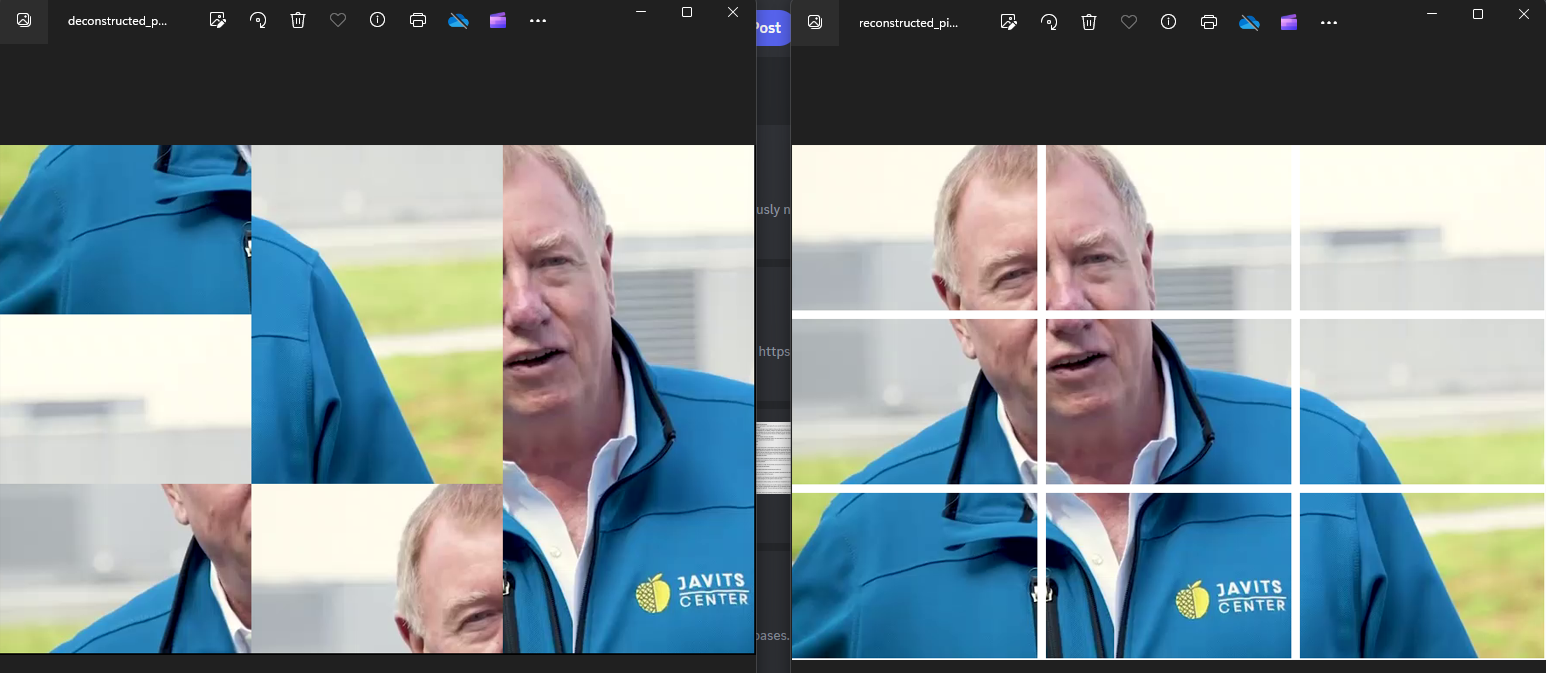


#### Extra credit (10 points)
Extra credit: if you want to maximize the possibility of developing something **new** think about how a video can be better segmented into representative frames. For example, [in this ~3min video accessed Nov 2023](https://youtu.be/FN8a8mZNik8?si=wXdbOGuLGkGsWsf) you have multiple scenes each one lasting 30sec or so. Can you find a way to segment each video and store the frame embeddings of each segment? This way there are multiple embeddings per video and you need to keep them that way for the subsequesnt steps of this project.

### Indexing the embeddings (20 points)

Use `docker compose` to bring up two docker containers, your application container with the dev environment (you must have done this in Step 1) and a second container with postgres.

`docker pull postgres:latest`

Process all the detected object sub-images for each frame of each video to compile your final results in the following tabular structure:
[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info, vector<embedding of this object>, optional<sceneId from extra credit>]

Index the video images embedding vectors in the database. To do that in postgres (with the pgvector extension) you can use [this guide](https://dev.to/sfoteini/image-vector-similarity-search-with-azure-computer-vision-and-postgresql-12f7).

Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.


#### SMALL ISSUE

I wanted to update you on my progress with the project, specifically regarding the setup of Docker and PostgreSQL. Unfortunately, I encountered significant challenges in getting them to work properly. However, I've managed to find a workaround that I believe will suffice for the time being.

To address the requirements of sections 2.2 and 2.3, I selected a video from the initial tasks, trimmed it to approximately 10 seconds, and successfully executed the code on local machines. it did worked and i was able to commit it onto the git as well so I hope youll understand. I have explained the rest of the codes in the README. Thanks
